In [18]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


now, let's load the datasets:


In [2]:
df_inventory = pd.read_parquet('local_data/inventory.parquet', engine='pyarrow')
df_abandoned_carts = pd.read_parquet('local_data/abandoned_carts.parquet', engine='pyarrow')
df_orders = pd.read_parquet('local_data/orders.parquet', engine='pyarrow')
df_regulars = pd.read_parquet('local_data/regulars.parquet', engine='pyarrow')
df_users = pd.read_parquet('local_data/users.parquet', engine='pyarrow')

let's now check what products are the most purchased and which ones are the most abandoned:

       product_id  number_of_orders  purchase_probability  \
0  33615294398596              88.0              0.010031   
1  33667174301828              13.0              0.001482   
2  33667174334596              15.0              0.001710   
3  33667174465668              65.0              0.007409   
4  33667174498436              78.0              0.008891   

   number_of_abandoned  abandon_probability  
0                 18.0             0.003299  
1                  2.0             0.000367  
2                  4.0             0.000733  
3                  9.0             0.001649  
4                  6.0             0.001100  
Guardando el gráfico...
Gráfico guardado.


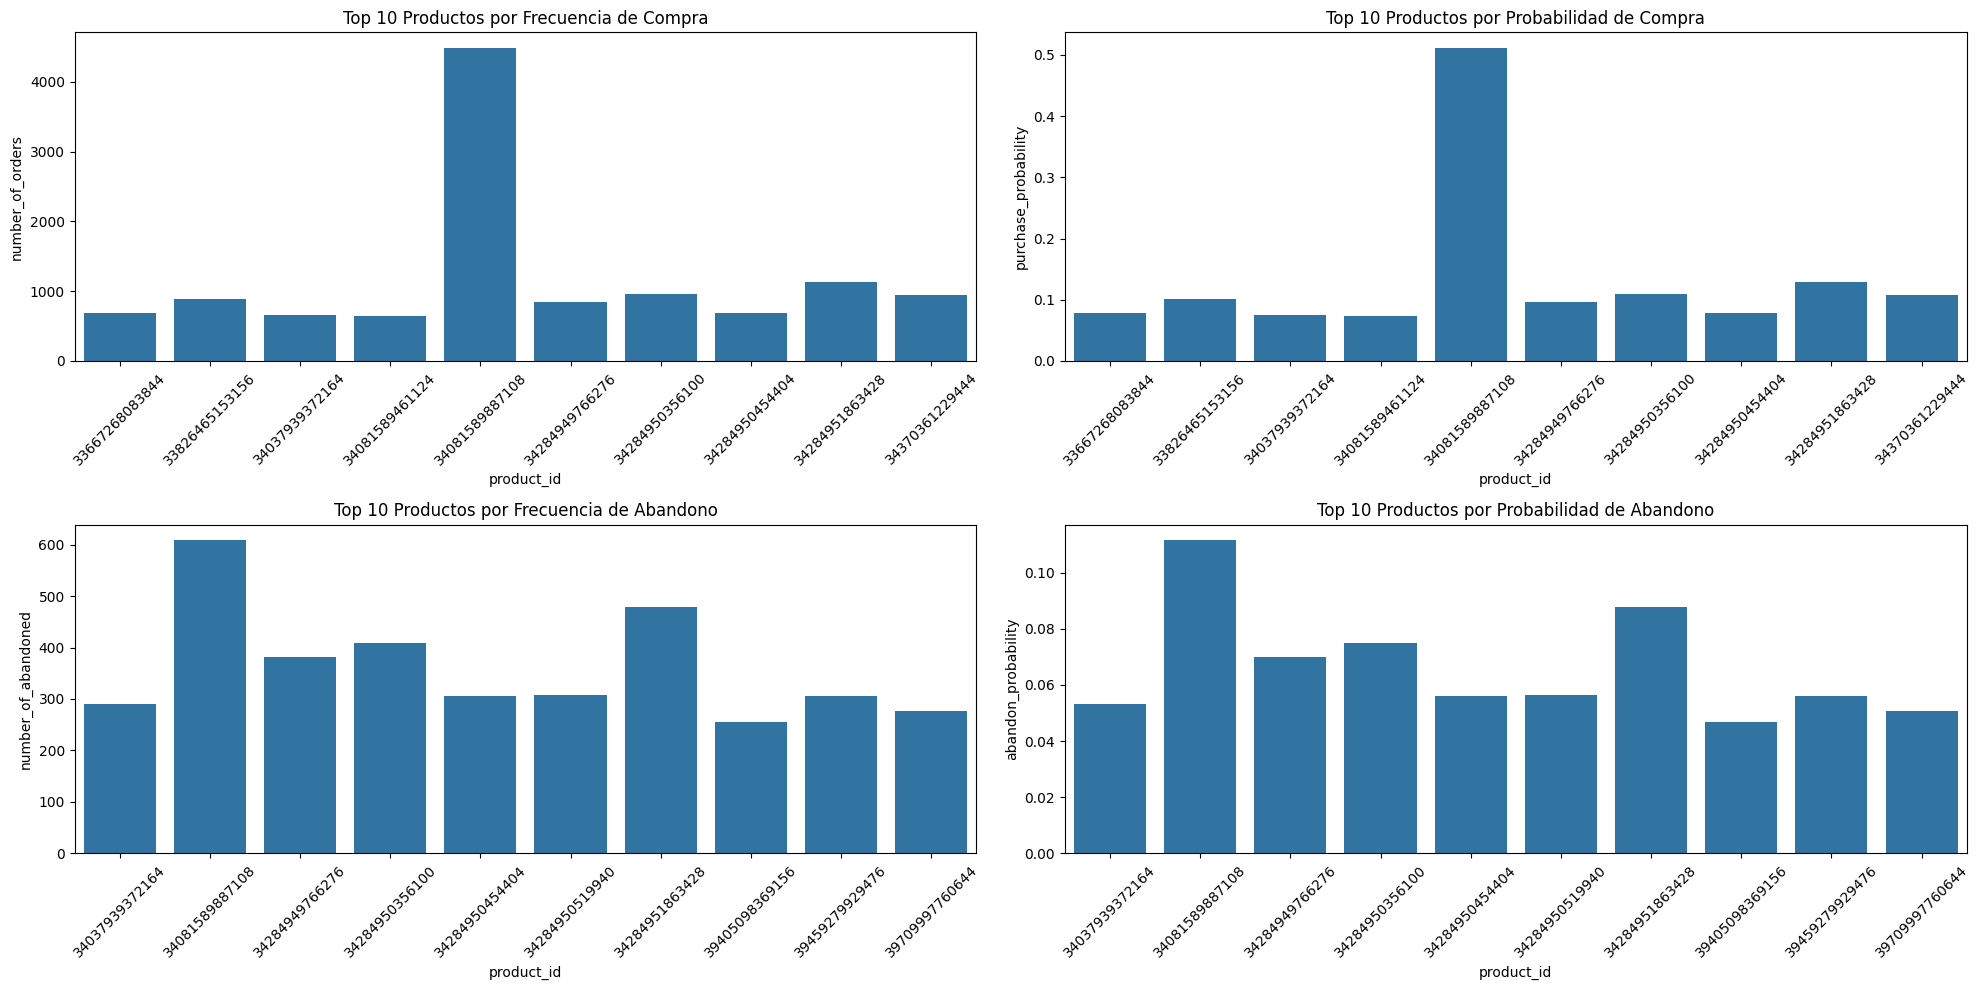

,product_id,number_of_orders,purchase_probability,number_of_abandoned,abandon_probability
0,33615294398596,88.0,0.010031,18.0,0.003299
1,33667174301828,13.0,0.001482,2.0,0.000367
2,33667174334596,15.0,0.001710,4.0,0.000733
3,33667174465668,65.0,0.007409,9.0,0.001649
4,33667174498436,78.0,0.008891,6.0,0.001100
...,...,...,...,...,...
1497,40091799617668,0.0,0.000000,1.0,0.000183
1498,40091799945348,1.0,0.000114,4.0,0.000733
1499,40091799978116,10.0,0.001140,6.0,0.001100
1500,40155145044100,2.0,0.000228,4.0,0.000733


In [8]:
def combinar_datasets_totales(): 
    # Paso 1: Crear DataFrame de pedidos
    exploded_items = df_orders['ordered_items'].explode()  
    item_counts = exploded_items.value_counts()
    item_counts_df_orders = item_counts.reset_index()
    item_counts_df_orders.columns = ['product_id', 'number_of_orders']
    total_orders = len(df_orders)
    item_counts_df_orders['purchase_probability'] = item_counts_df_orders['number_of_orders'] / total_orders
    #print("primeros cinco df orders: ", item_counts_df_orders.head())

    # Paso 2: Crear DataFrame de carritos abandonados
    exploded_items_abandoned = df_abandoned_carts['variant_id'].explode()
    item_counts_abandoned = exploded_items_abandoned.value_counts()
    item_counts_df_abandoned = item_counts_abandoned.reset_index()
    item_counts_df_abandoned.columns = ['product_id', 'number_of_abandoned']
    total_abandoned_carts = len(df_abandoned_carts)
    item_counts_df_abandoned['abandon_probability'] = item_counts_df_abandoned['number_of_abandoned'] / total_abandoned_carts
    #print("primeros cinco df abandoned: ", item_counts_df_abandoned.head())

    # Paso 3: Filtrar para incluir solo productos en inventario
    df_orders_inventory = item_counts_df_orders[item_counts_df_orders["product_id"].isin(df_inventory["variant_id"])]
    df_abandoned_inventory = item_counts_df_abandoned[item_counts_df_abandoned["product_id"].isin(df_inventory["variant_id"])]

    # Paso 4: Combinar los DataFrames
    df_combined = df_orders_inventory.merge(df_abandoned_inventory, on="product_id", how="outer")

    # Rellenar valores NaN con 0, ya que algunos productos pueden no estar en ambos DataFrames
    df_combined.fillna(0, inplace=True)
    print(df_combined.head())
    plt.figure(figsize=(20, 10))

    # Top 10 productos por frecuencia de compra
    plt.subplot(2, 2, 1)
    sns.barplot(x='product_id', y='number_of_orders', data=df_combined.sort_values('number_of_orders', ascending=False).head(10))
    plt.title('Top 10 Productos por Frecuencia de Compra')
    plt.xticks(rotation=45)

    # Top 10 productos por probabilidad de compra
    plt.subplot(2, 2, 2)
    sns.barplot(x='product_id', y='purchase_probability', data=df_combined.sort_values('purchase_probability', ascending=False).head(10))
    plt.title('Top 10 Productos por Probabilidad de Compra')
    plt.xticks(rotation=45)

    # Top 10 productos por frecuencia de abandono
    plt.subplot(2, 2, 3)
    sns.barplot(x='product_id', y='number_of_abandoned', data=df_combined.sort_values('number_of_abandoned', ascending=False).head(10))
    plt.title('Top 10 Productos por Frecuencia de Abandono')
    plt.xticks(rotation=45)

    # Top 10 productos por probabilidad de abandono
    plt.subplot(2, 2, 4)
    sns.barplot(x='product_id', y='abandon_probability', data=df_combined.sort_values('abandon_probability', ascending=False).head(10))
    plt.title('Top 10 Productos por Probabilidad de Abandono')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    print("Guardando el gráfico...")
    plt.savefig('/home/edu/zrive-ds-1/zrive-ds/src/module_2/graphs/graph_1.png')
    print("Gráfico guardado.")
    plt.show()
    plt.close()
    
    return df_combined
    

combinar_datasets_totales()


one of the things we expect at first in our bussiness is that if price is reduced, customers
will be more attracted to that product than before and therefor will have a bigger purchased probability.
Let's consider a significat discount those bigger than the 20%. If there's a "significant discount", then 
we believe there'll be more purchase probability than if there was less %


In [10]:
def probability_per_discount_check(percentage):
    data=df_inventory
    menos=[]
    mas=[]
    for index, row in data.iterrows():
        if row['compare_at_price'] == 0:
            # Opción 1: Continuar con la siguiente iteración
            continue

            # Opción 2: Establecer el porcentaje de descuento en cero o algún valor predeterminado
            # porcentaje_descuento = 0
        else:
            descuento = row['compare_at_price'] - row['price']
            porcentaje_descuento = (descuento / row['compare_at_price']) * 100

            # Comparar el porcentaje de descuento
            if porcentaje_descuento > percentage:
                mas.append(row['variant_id'])
            else:
                menos.append(row['variant_id'])
    
    # Crear subdataframes
    df_mas = data[data['variant_id'].isin(mas)]
    df_menos = data[data['variant_id'].isin(menos)]
    
    # Calcular la probabilidad de ser comprado
    total_orders = df_orders['ordered_items'].explode().value_counts()
    df_mas['purchase_probability'] = df_mas['variant_id'].apply(lambda x: total_orders.get(x, 0) / len(df_orders))
    df_menos['purchase_probability'] = df_menos['variant_id'].apply(lambda x: total_orders.get(x, 0) / len(df_orders))
    print(df_mas.head(),df_menos.head())
    return df_mas, df_menos

probability_per_discount_check(50)

         variant_id  price  compare_at_price vendor       product_type  \
23   39830155034756   4.49              9.00    cif  cleaning-products   
26   39459281272964   4.49              9.00    cif  cleaning-products   
37   33667185279108   0.99              1.99    cif  cleaning-products   
104  34368927170692   0.83             11.99  mutti     cooking-sauces   
149  34369153564804   1.00              2.59  mutti     cooking-sauces   

                                                  tags  purchase_probability  
23                     [kitchen-oven-cleaner, refills]              0.005243  
26               [bathroom-limescale-cleaner, refills]              0.012310  
37        [bathroom-limescale-cleaner, toilet-cleaner]              0.033968  
104  [pasta-pizza-sauce, tinned-tomatoes-puree-pass...              0.000000  
149  [pasta-pizza-sauce, tinned-tomatoes-puree-pass...              0.000000          variant_id  price  compare_at_price          vendor  \
0  39587297165444  

/tmp/ipykernel_25655/4228338435.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mas['purchase_probability'] = df_mas['variant_id'].apply(lambda x: total_orders.get(x, 0) / len(df_orders))
/tmp/ipykernel_25655/4228338435.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_menos['purchase_probability'] = df_menos['variant_id'].apply(lambda x: total_orders.get(x, 0) / len(df_orders))


(          variant_id  price  compare_at_price          vendor  \
 23    39830155034756   4.49              9.00             cif   
 26    39459281272964   4.49              9.00             cif   
 37    33667185279108   0.99              1.99             cif   
 104   34368927170692   0.83             11.99           mutti   
 149   34369153564804   1.00              2.59           mutti   
 182   39459279798404   1.99              4.18        vaseline   
 184   33667185311876   0.99              1.99             cif   
 220   34173021192324   2.69              5.79          ribena   
 275   34246816923780   1.49              3.00             cif   
 394   33719433986180   1.49              2.99           oralb   
 400   39600950411396   2.69              5.56           biona   
 406   39600950378628   2.49              5.16           biona   
 460   34415988179076   1.99              3.99  herbalessences   
 585   33719435657348   1.99              3.99  herbalessences   
 619   344

However, our analysis indicates that the impact of discounts on our product sales is minimal, unless the discount is significantly substantial to attract customer attention. This insight leads us to consider a strategic pivot for our online store. It may be prudent to concentrate our efforts on a select range of target products. Which products should these be? Let's explore this further

Guardando el gráfico...
Gráfico guardado.


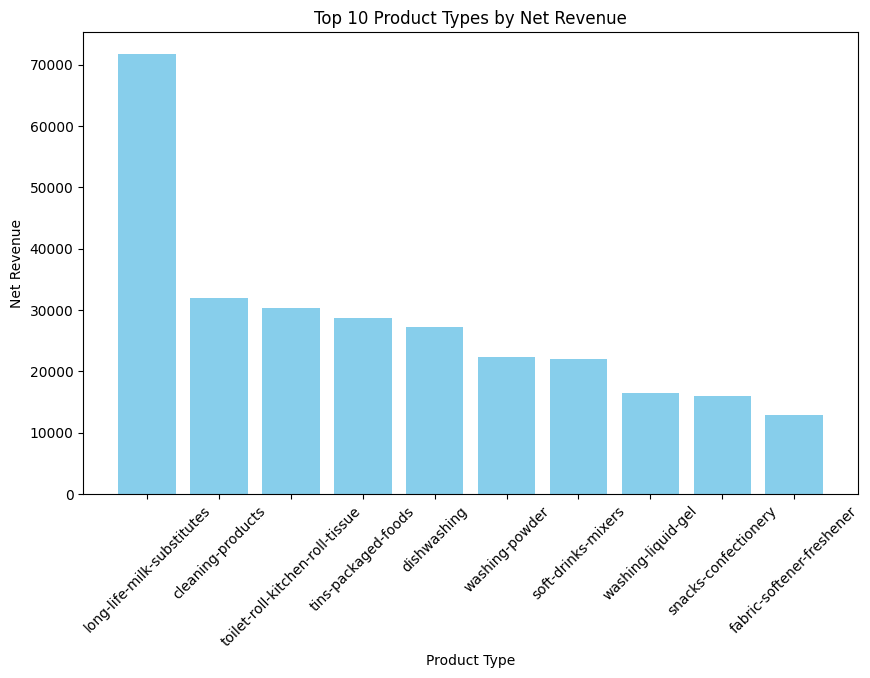

,product_type,order_count,abandoned_count,net_revenue,maximized_possible_revenue
29,long-life-milk-substitutes,6637,1134,71736.70,83952.76
12,cleaning-products,9676,2525,31948.04,40603.69
52,toilet-roll-kitchen-roll-tissue,6314,2257,30270.66,41988.29
51,tins-packaged-foods,8959,2700,28662.86,37653.79
20,dishwashing,4362,1694,27163.98,38324.04
55,washing-powder,1475,511,22321.75,30124.64
45,soft-drinks-mixers,3808,1769,22008.82,33593.13
54,washing-liquid-gel,1482,615,16389.18,23250.63
44,snacks-confectionery,3787,1157,15958.63,21548.46
23,fabric-softener-freshener,2443,1070,12867.07,18801.37


In [13]:
def contar_pedidos_por_tipo(): #nos da un graph e info sobre los product_type mas demandados
    variant_info = df_inventory.set_index('variant_id')[['product_type', 'price']]

    # Filtrar variant_id en df_orders y df_abandoned_carts que están en df_inventory
    valid_variants = set(df_inventory['variant_id'])
    ordered_variants = df_orders['ordered_items'].explode().map(lambda x: x if x in valid_variants else None).dropna()
    abandoned_variants = df_abandoned_carts['variant_id'].explode().map(lambda x: x if x in valid_variants else None).dropna()
    
    # Asignar product_type y price a cada variant_id en los pedidos y en los abandonos
    ordered_variants_info = variant_info.loc[ordered_variants]
    abandoned_variants_info = variant_info.loc[abandoned_variants]

    # Calcular ingresos por variant_id
    ordered_variants_info['revenue'] = ordered_variants_info['price']
    abandoned_variants_info['lost_revenue'] = abandoned_variants_info['price']

    # Agregar y agrupar por product_type
    revenue_per_type = ordered_variants_info.groupby('product_type')['revenue'].sum()
    lost_revenue_per_type = abandoned_variants_info.groupby('product_type')['lost_revenue'].sum()
    maximized_possible_revenue = revenue_per_type + lost_revenue_per_type

    # Calcular ingresos netos por product_type
    #net_revenue_per_type = revenue_per_type - lost_revenue_per_type
    net_revenue_per_type = revenue_per_type 

    # Contar pedidos y abandonos por product_type
    order_counts = ordered_variants_info['product_type'].value_counts()
    abandoned_counts = abandoned_variants_info['product_type'].value_counts()

    # Crear un nuevo DataFrame
    top_types = pd.DataFrame({
        'order_count': order_counts,
        'abandoned_count': abandoned_counts.reindex(order_counts.index, fill_value=0),
        'net_revenue': net_revenue_per_type.reindex(order_counts.index, fill_value=0),
        'maximized_possible_revenue': maximized_possible_revenue.reindex(maximized_possible_revenue.index, fill_value=0)
    }).reset_index().rename(columns={'index': 'product_type'})

    # Ordenar por ingresos netos (net_revenue) de mayor a menor
    top_types = top_types.sort_values(by='net_revenue', ascending=False)
    
    top_types = top_types.sort_values(by='net_revenue', ascending=False)
    top_10_types = top_types.head(10)
    
    #print(top_10_types)

    # Crear un gráfico de barras para el ingreso neto de las 10 principales categorías
    plt.figure(figsize=(10, 6))
    plt.bar(top_10_types['product_type'], top_10_types['net_revenue'], color='skyblue')
    plt.xlabel('Product Type')
    plt.ylabel('Net Revenue')
    plt.title('Top 10 Product Types by Net Revenue')
    plt.xticks(rotation=45)
    print("Guardando el gráfico...")
    plt.savefig('/home/edu/zrive-ds-1/zrive-ds/src/module_2/graphs/graph_1.png')
    print("Gráfico guardado.")
    plt.show()
    plt.close()

    return top_types
contar_pedidos_por_tipo()

We can see the net revenue per product type, which is caluclated using the total sales. There's a huge difference between some of the product types; which basically can lead to either focusing on increasing those sales of the products with less revenue, maybe with more ads or any marketing strategy for it, or just focusing in a very specific nicht. Also we can see that due to abandoned carts there's being lost a lot of possible income to the bussiness. Therefore, another important aspect we could analyse is how to reduce the amount of these abandoned carts. When are more succesful orders? Should we create a strategy to increase sales at determined times? 

In [15]:
def best_users_product_type():
    # Mapear variant_id a product_type
    variant_info = df_inventory.set_index('variant_id')[['product_type', 'price']].to_dict('index')

    # Expandir los items ordenados y abandonados en df_orders y df_abandoned_carts
    expanded_orders = df_orders.explode('ordered_items')
    expanded_abandoned = df_abandoned_carts.explode('variant_id')

    # Filtrar variant_id en df_orders y df_abandoned_carts que están en df_inventory
    valid_variants = set(df_inventory['variant_id'])
    expanded_orders = expanded_orders[expanded_orders['ordered_items'].isin(valid_variants)]
    expanded_abandoned = expanded_abandoned[expanded_abandoned['variant_id'].isin(valid_variants)]

    # Asignar product_type y price a cada variant_id en los pedidos y abandonos
    expanded_orders['product_type'] = expanded_orders['ordered_items'].map(lambda x: variant_info[x]['product_type'])
    expanded_orders['price'] = expanded_orders['ordered_items'].map(lambda x: variant_info[x]['price'])
    expanded_abandoned['product_type'] = expanded_abandoned['variant_id'].map(lambda x: variant_info[x]['product_type'])

    # Función para manejar grupos vacíos al encontrar el product_type más común
    def most_common_product_type(x):
        if len(x) > 0:
            return x.value_counts().idxmax()
        else:
            return None

    # Contar pedidos, abandonos y encontrar product_type más común por user_id
    user_order_counts = expanded_orders['user_id'].value_counts()
    user_abandoned_counts = expanded_abandoned['user_id'].value_counts()
    most_bought_product_type = expanded_orders.groupby('user_id')['product_type'].agg(most_common_product_type)
    most_abandoned_product_type = expanded_abandoned.groupby('user_id')['product_type'].agg(most_common_product_type)

    # Calcular el revenue por usuario
    revenue_per_user = expanded_orders.groupby('user_id')['price'].sum()

   # Crear un nuevo DataFrame
    best_users = pd.DataFrame({
        'user_id': user_order_counts.index,
        'order_count': user_order_counts,
        'most_bought_product_type': most_bought_product_type,
        'abandoned_count': user_abandoned_counts.reindex(user_order_counts.index, fill_value=0),
        'most_abandoned_product_type': most_abandoned_product_type.reindex(user_order_counts.index),
        'revenue': revenue_per_user
    }).reset_index(drop=True)

    # Ordenar el DataFrame por 'revenue' en orden descendente
    best_users = best_users.sort_values(by='revenue', ascending=False)

    print(best_users.head())
    return best_users

best_users_product_type()

                                                user_id  order_count  \
83    d7d080eceb0168ebdff0002e4c8e1dcc3fd1912c602c95...          311   
3635  29299f2e8ca82be713e716c0de8738f0e5f9c878f4de7a...          167   
3242  d26a41d67114911b309aa68d94ab32a47334af761e6a29...          448   
2260  4021cf86ce45a4fe0793a16fa6c5f8c0fc104d56cf93a4...          383   
1258  f49d903f33fde7436da05a2dc6eddebff62cd9ca552121...          337   

             most_bought_product_type  abandoned_count  \
83                             cereal                5   
3635       long-life-milk-substitutes                7   
3242             snacks-confectionery               47   
2260                cleaning-products                6   
1258  toilet-roll-kitchen-roll-tissue               41   

     most_abandoned_product_type  revenue  
83          snacks-confectionery  1969.99  
3635  long-life-milk-substitutes  1781.73  
3242          pasta-rice-noodles  1756.21  
2260           cleaning-products  1738.17 

,user_id,order_count,most_bought_product_type,abandoned_count,most_abandoned_product_type,revenue
83,d7d080eceb0168ebdff0002e4c8e1dcc3fd1912c602c95...,311,cereal,5,snacks-confectionery,1969.99
3635,29299f2e8ca82be713e716c0de8738f0e5f9c878f4de7a...,167,long-life-milk-substitutes,7,long-life-milk-substitutes,1781.73
3242,d26a41d67114911b309aa68d94ab32a47334af761e6a29...,448,snacks-confectionery,47,pasta-rice-noodles,1756.21
2260,4021cf86ce45a4fe0793a16fa6c5f8c0fc104d56cf93a4...,383,cleaning-products,6,cleaning-products,1738.17
1258,f49d903f33fde7436da05a2dc6eddebff62cd9ca552121...,337,toilet-roll-kitchen-roll-tissue,41,dishwashing,1617.47
...,...,...,...,...,...,...
1756,769555ec9d277b7fa4a55e7f5c00f27017afbb52cc5056...,2,tins-packaged-foods,0,NaN,2.98
1654,70b771db8fe2d0c96f12e1b53b472ea646f16be0f7ce34...,1,cooking-ingredients,0,NaN,2.29
89,864e7f2d544ae108b74798fcfc61b4cf23e16d84921f35...,1,cleaning-products,0,NaN,1.99
1507,2d4dca7ab4ae6e5b3fc418d971ee8ad74462d63093db04...,1,cooking-ingredients,1,cooking-ingredients,0.99


As we can see, the favourite product types of the clients with highest revenues are among the most bought product types. So now, the main aspect to check is, when is the time where more carts are abandoned and what type of products belong to these carts? 

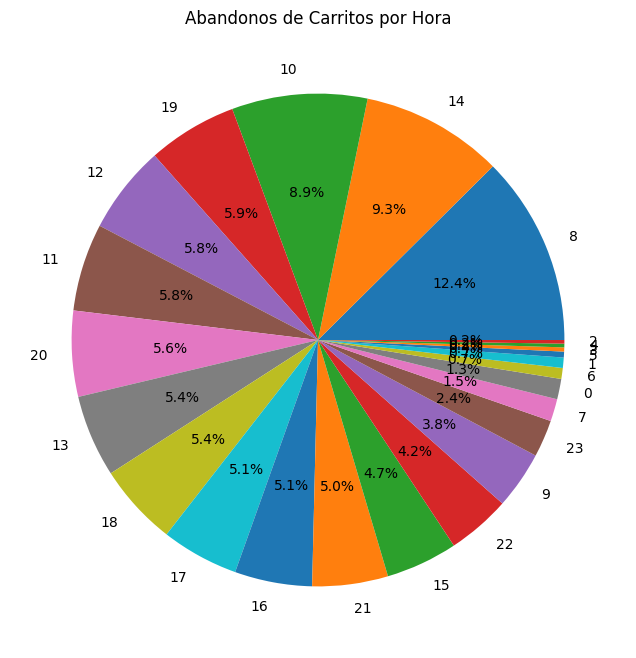

Guardando el gráfico...
Gráfico guardado.


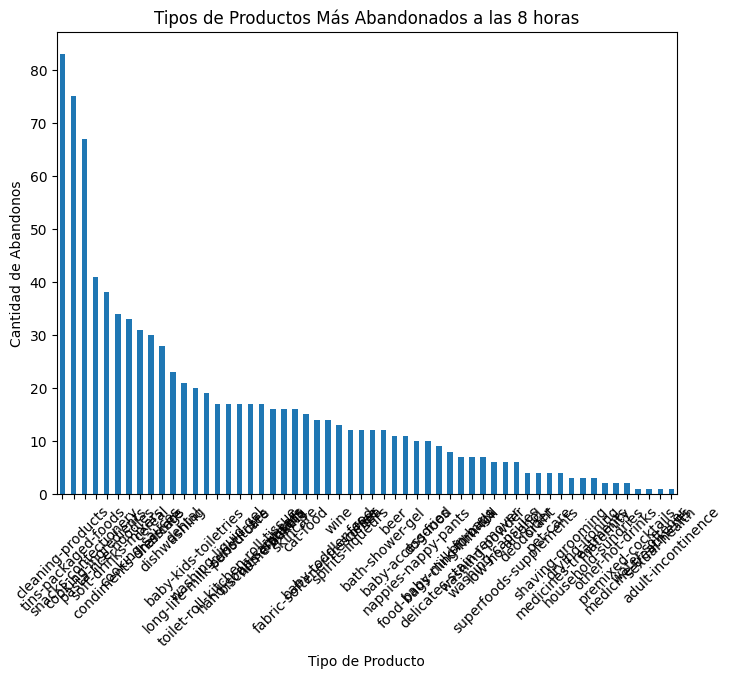

Guardando el gráfico...
Gráfico guardado.


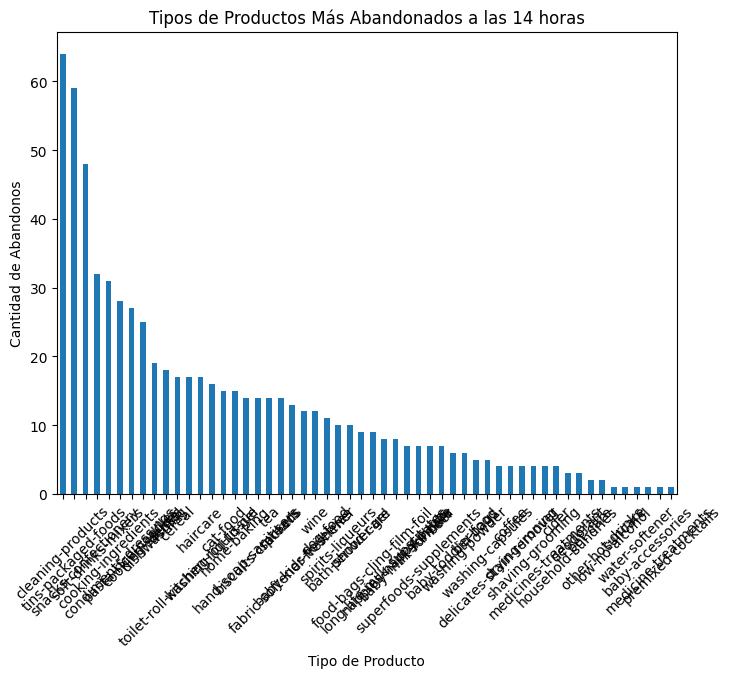

Guardando el gráfico...
Gráfico guardado.


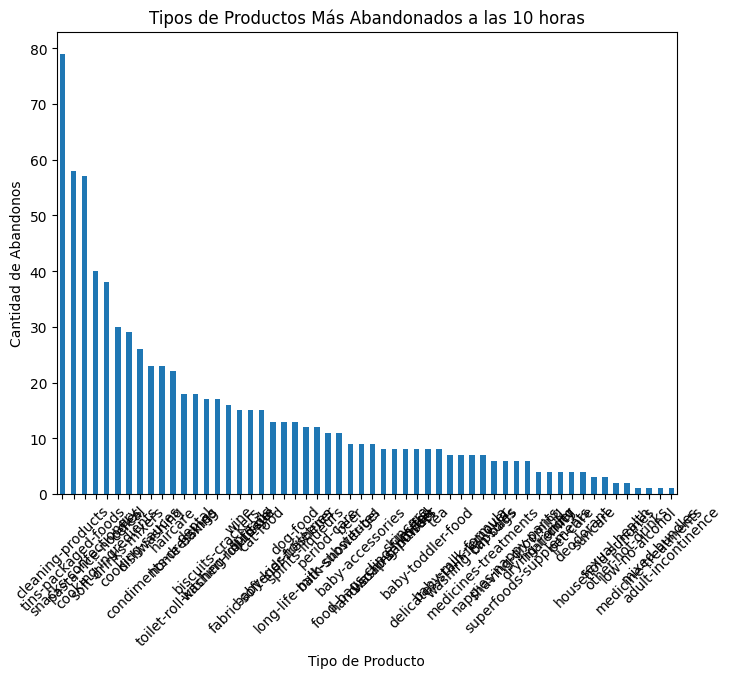

In [21]:
def analyze_abandoned_carts():
    # Convertir timestamp a hora
    df_abandoned_carts['hour'] = df_abandoned_carts['created_at'].dt.hour

    # Conteo de abandonos por hora
    hour_counts = df_abandoned_carts['hour'].value_counts()

    # Gráfico circular de abandonos por hora
    plt.figure(figsize=(8, 8))
    hour_counts.plot(kind='pie', autopct='%1.1f%%')
    plt.title('Abandonos de Carritos por Hora')
    plt.ylabel('')
    plt.show()

    # Obtener las tres horas con más abandonos
    top_hours = hour_counts.head(3).index

    # Analizar los tipos de productos más abandonados en esas horas
    for hour in top_hours:
        # Filtrar carritos abandonados en la hora específica
        hour_abandoned = df_abandoned_carts[df_abandoned_carts['hour'] == hour]
        
        # Obtener los variant_id y luego los product_type
        variant_ids = hour_abandoned['variant_id'].explode()
        product_types = df_inventory[df_inventory['variant_id'].isin(variant_ids)]['product_type']

        # Conteo de product_types
        product_type_counts = product_types.value_counts()

        # Gráfico de los tipos de productos abandonados
        plt.figure(figsize=(8, 6))
        product_type_counts.plot(kind='bar')
        plt.title(f'Tipos de Productos Más Abandonados a las {hour} horas')
        plt.xlabel('Tipo de Producto')
        plt.ylabel('Cantidad de Abandonos')
        plt.xticks(rotation=45)
   

        print("Guardando el gráfico...")
        plt.savefig('/home/edu/zrive-ds-1/zrive-ds/src/module_2/graphs/graph_1.png')
        print("Gráfico guardado.")
        plt.show()
        plt.close()
        
analyze_abandoned_carts()
        

The most carts abandoned are at 8 am, probably because people is in a rush in the morning, at 10 am and at 14 pm. At all these times, the most abandoned product type is the cleaning products. Who likes cleaning? and who likes cleaning in the morning or just when you are hungry at 14h?

